<a href="https://colab.research.google.com/github/Arvind-55555/Measuring-CO-sequestration-of-a-tree/blob/main/Measuring_CO%E2%82%82_sequestration_of_a_tree_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

**Generate Hypothetical Data:**

We use numpy to generate a sample of trees with features like:

* **species:** Categorical values (Oak, Pine, Maple, Birch).

* **dbh:** Diameter at breast height (cm).

* **height:** Tree height (meters).

* **annual_co2_seq:** Estimated annual CO₂ sequestration, which we model based on other tree features, location and growth factors.

We create a pandas DataFrame for easy manipulation.

In [2]:
# 1. Generate Hypothetical Data
np.random.seed(42) #For reproducibility

n_samples = 1000

species = np.random.choice(['Oak', 'Pine', 'Maple', 'Birch'], size=n_samples)
dbh = np.random.uniform(5, 50, size=n_samples) # DBH in cm
height = np.random.uniform(5, 30, size=n_samples)  # Height in meters
location_effect = np.where(species == 'Oak', 1.2,1) #Oak tends to grow in favorable locations
annual_growth_factor = np.random.uniform(0.02, 0.05, size=n_samples) #Growth percentage every year
base_carbon_seq = 0.15*(dbh * height ) * location_effect #Base carbon sequestration calculation
annual_co2_seq = (base_carbon_seq * annual_growth_factor)* np.random.uniform(0.8, 1.2, size=n_samples)

In [16]:
df = pd.DataFrame({'species': species,
                   'dbh': dbh,
                   'height': height,
                   'annual_co2_seq': annual_co2_seq})
df.head(10)

,species,dbh,height,annual_co2_seq
0,Maple,36.417277,17.977045,4.026037
1,Birch,29.124336,16.979547,3.570431
2,Oak,18.928743,5.641052,0.857328
3,Maple,41.620776,13.531196,3.339353
4,Maple,35.812903,14.504890,2.349198
5,Birch,12.317762,14.970570,0.675465
6,Oak,45.991723,19.504309,8.760683
7,Oak,42.014176,18.340064,4.536826
8,Maple,47.740996,20.197627,7.480529
9,Pine,37.657378,24.122082,5.259760


**Data Preprocessing:**

We split the data into features (X) and the target variable (y).

We split data to train and test data sets to evaluate the model performance with data not used for training.

ColumnTransformer is used to:

* **Scale numeric features** (dbh, height) using StandardScaler (subtracting mean and dividing by standard deviation).

* **One-Hot Encode** the categorical feature species (convert each species into separate binary columns).

In [5]:
# 2. Data Preprocessing
# Define features and target
X = df.drop('annual_co2_seq', axis=1)
y = df['annual_co2_seq']

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define transformers for scaling and encoding
numeric_features = ['dbh','height']
categorical_features = ['species']

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [9]:
# Apply preprocessing to training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply preprocessing to test data (use the fitted scaler)
X_test_processed = preprocessor.transform(X_test)

**Model Training:**

We use a LinearRegression model as a starting point. We could try other models later.

We train the model using the processed training data (X_train_processed, y_train).



In [10]:
# 3. Model Training
model = LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

**Model Evaluation:**

We use the trained model to predict CO₂ sequestration on the test set.

We calculate the Mean Squared Error (MSE) and R-squared (R²) to evaluate the model's performance.

In [11]:
# 4. Model Evaluation
y_pred = model.predict(X_test_processed)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 1.01
R-squared: 0.76



Feature Importances:
              Feature  Importance
0            num__dbh    1.233163
1         num__height    1.089849
4    cat__species_Oak    0.387249
3  cat__species_Maple   -0.223226
2  cat__species_Birch   -0.095396
5   cat__species_Pine   -0.068626


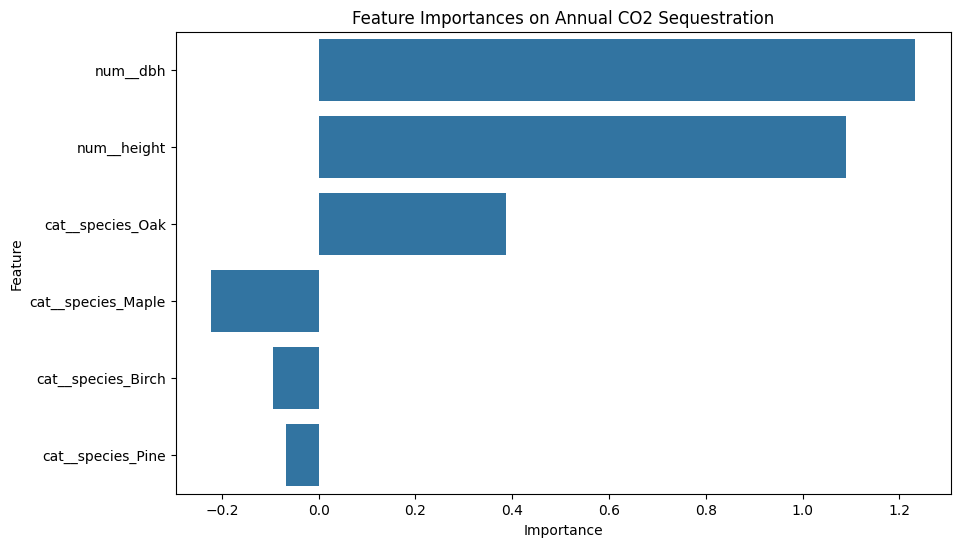

In [12]:
# 5. Analysis and Insights

# 5.1 Feature Importance
if hasattr(model, 'coef_'):
    feature_names = preprocessor.get_feature_names_out()
    feature_importance = pd.DataFrame({'Feature': feature_names,
                                       'Importance': model.coef_})
    feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)
    print("\nFeature Importances:")
    print(feature_importance)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance)
    plt.title("Feature Importances on Annual CO2 Sequestration")
    plt.show()

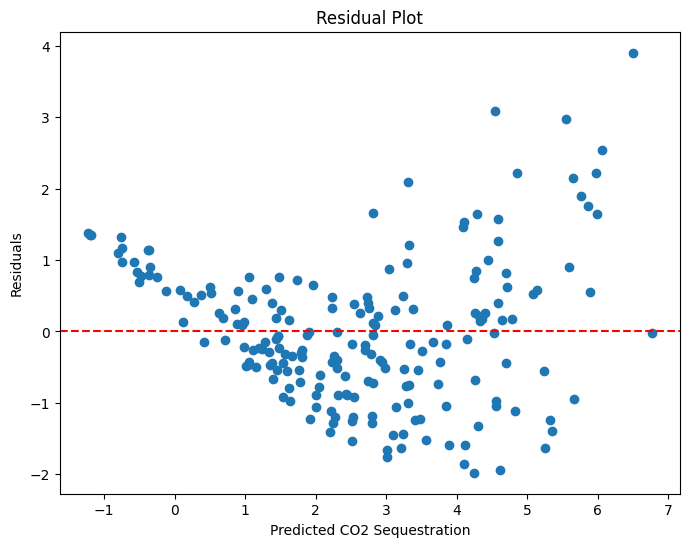

In [13]:
# 5.2 Residual Plot (check for model assumptions)

residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals)
plt.title("Residual Plot")
plt.xlabel("Predicted CO2 Sequestration")
plt.ylabel("Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.show()

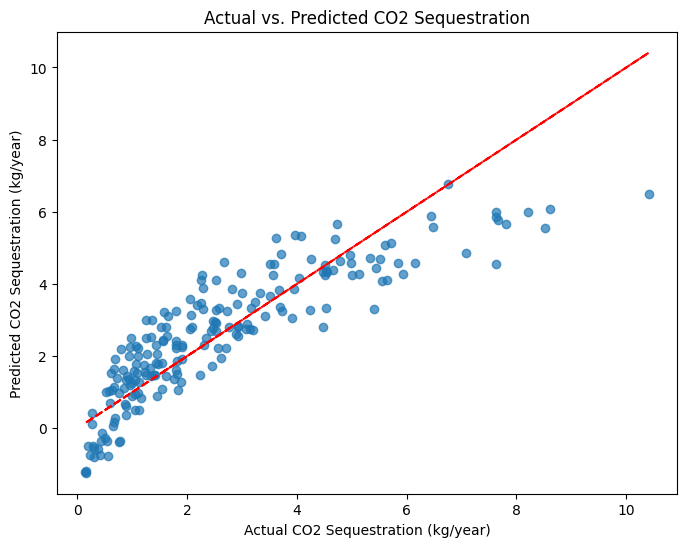

In [14]:
# 5.3 Visualize prediction
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual CO2 Sequestration (kg/year)")
plt.ylabel("Predicted CO2 Sequestration (kg/year)")
plt.title("Actual vs. Predicted CO2 Sequestration")
plt.plot(y_test,y_test, color="red", linestyle="--") #for perfect prediction reference
plt.show()

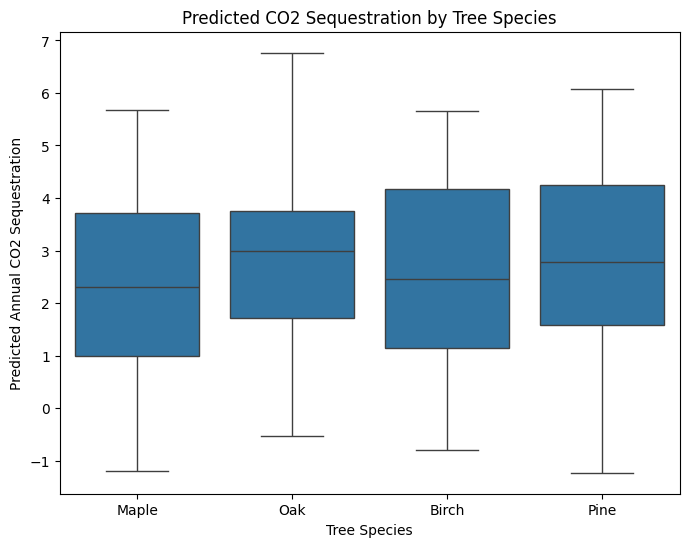

In [15]:
# 5.4 Investigate species influence on CO2 sequestration
df_pred = X_test.copy()
df_pred["predicted_co2_seq"] = y_pred
plt.figure(figsize=(8, 6))
sns.boxplot(x='species', y='predicted_co2_seq', data=df_pred)
plt.title("Predicted CO2 Sequestration by Tree Species")
plt.xlabel("Tree Species")
plt.ylabel("Predicted Annual CO2 Sequestration")
plt.show()